In [1]:
annos_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_annos'
images_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_image'

In [2]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  0%|          | 0/2000 [00:00<?, ?it/s]

Loaded 2000 images and 3297 labels.


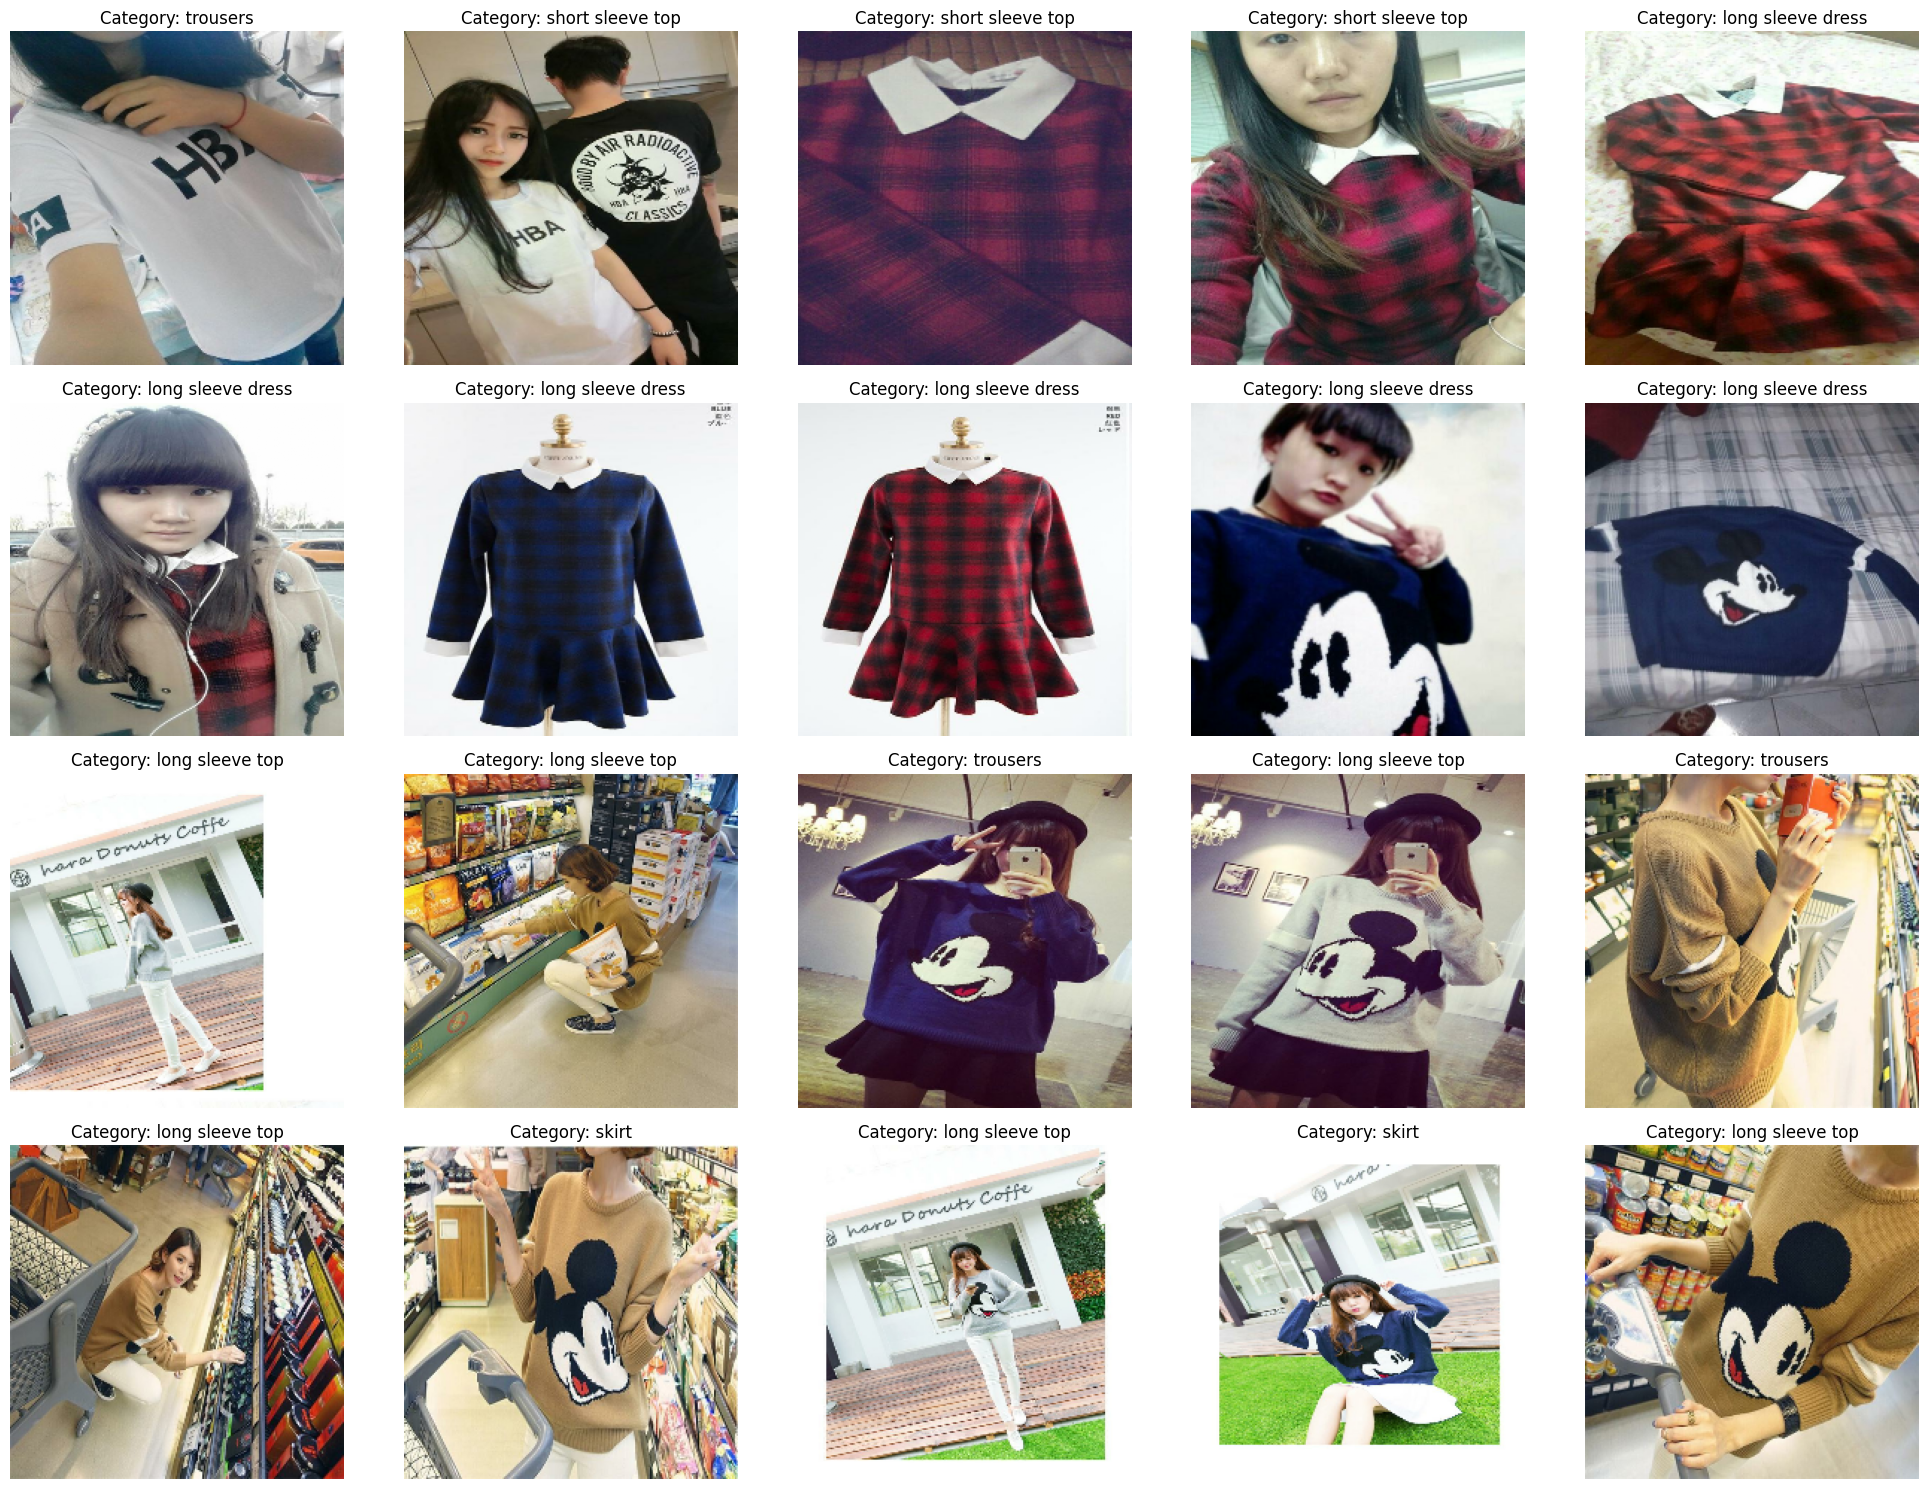

In [3]:
from tqdm.notebook import tqdm
import os
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = img / 255.0  # Normalize to [0, 1]
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_data(annos_path, images_path, max_samples=2000):
    images = []
    labels = []

    if not os.path.exists(annos_path) or not os.path.exists(images_path):
        print("Error: Provided paths do not exist.")
        return None, None

    anno_files = sorted(os.listdir(annos_path))[:max_samples]
    image_files = sorted(os.listdir(images_path))[:max_samples]

    for anno_file, image_file in tqdm(zip(anno_files, image_files), total=len(anno_files)):
        anno_path = os.path.join(annos_path, anno_file)
        image_path = os.path.join(images_path, image_file)

        img = load_and_preprocess_image(image_path)
        if img is not None:
            images.append(img)


        try:
            with open(anno_path, 'r') as f:
                annotation = json.load(f)
                for item_key, item_value in annotation.items():
                    if item_key.startswith('item'):
                        category_name = item_value.get('category_name', "Unknown")
                        labels.append(category_name)
        except Exception as e:
            print(f"Error reading annotation {anno_file}: {e}")

    return tf.stack(images), np.array(labels)


annos_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_annos'
images_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_image'

# Load the data for a subset of 2000 images
train_images, train_labels = load_data(annos_path, images_path, max_samples=2000)

if train_images is not None and train_labels is not None:
    print(f"Loaded {len(train_images)} images and {len(train_labels)} labels.")
else:
    print("Failed to load data.")

# Function to display images with their categories
def display_images_with_categories(images, categories, nrows=4, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15))
    axes = axes.flatten()
    for img, cat, ax in zip(images, categories, axes):
        ax.imshow(img)
        ax.set_title(f"Category: {cat}", fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


if train_images is not None and train_labels is not None:
    sample_images = train_images[:20]
    sample_categories = train_labels[:20]
    display_images_with_categories(sample_images, sample_categories)


In [4]:
import os 
import json
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm

def find_duplicates(file_paths):
    file_hashes = {}
    duplicates = []

    for file_path in file_paths:
        try:
            with open(file_path, 'rb') as f:
                file_hash = hash(f.read())
                if file_hash in file_hashes:
                    duplicates.append(file_path)
                else:
                    file_hashes[file_hash] = file_path
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    return duplicates


def validate_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        return True
    except Exception as e:
        print(f"Invalid image file {file_path}: {e}")
        return False

def validate_annotation(file_path):
    try:
        with open(file_path, 'r') as f:
            annotation = json.load(f)
            # Check for required fields
            if 'category_name' not in annotation:
                print(f"Missing category_name in {file_path}")
                return False
        return True
    except Exception as e:
        print(f"Invalid annotation file {file_path}: {e}")
        return False


annos_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_annos'
images_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_image'


anno_files = [os.path.join(annos_path, f) for f in os.listdir(annos_path)]
image_files = [os.path.join(images_path, f) for f in os.listdir(images_path)]


duplicate_annos = find_duplicates(anno_files)
duplicate_images = find_duplicates(image_files)

print(f"Found {len(duplicate_annos)} duplicate annotation files.")
print(f"Found {len(duplicate_images)} duplicate image files.")


for file_path in duplicate_annos + duplicate_images:
    try:
        os.remove(file_path)
        print(f"Removed duplicate file {file_path}")
    except Exception as e:
        print(f"Error removing file {file_path}: {e}")


Found 0 duplicate annotation files.
Found 0 duplicate image files.


In [5]:
import os
import json
import tensorflow as tf
from tqdm.notebook import tqdm

annos_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_annos'
images_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_image'

# Function to check for valid image files
def validate_image(file_path):
    try:
        # Read and decode image file
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        return True
    except Exception as e:
        print(f"Invalid image file {file_path}: {e}")
        return False

def validate_annotation(file_path):
    try:
        with open(file_path, 'r') as f:
            annotation = json.load(f)
            # Check if JSON is empty
            if not annotation:
                print(f"Empty JSON file: {file_path}")
                return False
            # Further validation can be added here if needed
        return True
    except json.JSONDecodeError:
        print(f"JSON decode error for {file_path}")
        return False
    except Exception as e:
        print(f"Error reading annotation file {file_path}: {e}")
        return False


def filter_valid_files(image_files, anno_files, max_samples=2000):
    valid_images = []
    valid_annos = []
    for image_file, anno_file in tqdm(zip(image_files[:max_samples], anno_files[:max_samples]), total=max_samples):
        if validate_image(image_file) and validate_annotation(anno_file):
            valid_images.append(image_file)
            valid_annos.append(anno_file)
    return valid_images, valid_annos

anno_files = [os.path.join(annos_path, f) for f in os.listdir(annos_path)][:2000]
image_files = [os.path.join(images_path, f) for f in os.listdir(images_path)][:2000]


valid_image_files, valid_anno_files = filter_valid_files(image_files, anno_files, max_samples=2000)

print(f"Total valid images: {len(valid_image_files)}")
print(f"Total valid annotations: {len(valid_anno_files)}")


invalid_images = set(image_files) - set(valid_image_files)
invalid_annos = set(anno_files) - set(valid_anno_files)

print("\nInvalid Image Files:")
for img in invalid_images:
    print(img)

print("\nInvalid Annotation Files:")
for ann in invalid_annos:
    print(ann)


  0%|          | 0/2000 [00:00<?, ?it/s]

Total valid images: 2000
Total valid annotations: 2000

Invalid Image Files:

Invalid Annotation Files:


In [6]:
# Verify that all images are of the same size
image_shapes = [img.shape for img in train_images]
unique_shapes = set(image_shapes)

if len(unique_shapes) > 1:
    print("Found images of different sizes. Normalizing all images to the same size.")
    train_images = np.array([tf.image.resize(img, (224, 224)).numpy() for img in train_images])
    print("Images resized successfully.")
else:
    print("All images have the same size.")

All images have the same size.


In [7]:
def extract_unique_categories(annos_path, max_samples=2000):
    unique_categories = set()
    anno_files = sorted(os.listdir(annos_path))[:max_samples]

    for anno_file in tqdm(anno_files, total=len(anno_files)):
        anno_path = os.path.join(annos_path, anno_file)
        with open(anno_path, 'r') as f:
            annotation = json.load(f)
            for item_key, item_value in annotation.items():
                if item_key.startswith('item'):
                    category_id = item_value.get('category_name', -1)
                    unique_categories.add(category_id)

    return sorted(list(unique_categories))

# Test with a smaller subset
small_unique_categories = extract_unique_categories(annos_path)
print(f"Found {len(small_unique_categories)} unique categories in the subset:")
print(small_unique_categories)

  0%|          | 0/2000 [00:00<?, ?it/s]

Found 13 unique categories in the subset:
['long sleeve dress', 'long sleeve outwear', 'long sleeve top', 'short sleeve dress', 'short sleeve outwear', 'short sleeve top', 'shorts', 'skirt', 'sling', 'sling dress', 'trousers', 'vest', 'vest dress']


In [8]:
print(f"Found {len(small_unique_categories)} unique categories in the subset:")
for category_name in small_unique_categories:
    print(f"Category Name: {category_name}")

Found 13 unique categories in the subset:
Category Name: long sleeve dress
Category Name: long sleeve outwear
Category Name: long sleeve top
Category Name: short sleeve dress
Category Name: short sleeve outwear
Category Name: short sleeve top
Category Name: shorts
Category Name: skirt
Category Name: sling
Category Name: sling dress
Category Name: trousers
Category Name: vest
Category Name: vest dress


In [9]:
from tqdm.notebook import tqdm
import os
import json
from collections import Counter

annos_path =  'D:/Infosys Springboard Project(clothing personal stylist)/sub_annos'

def count_category_distribution(annos_path, max_samples=2000):
    category_count = Counter()
    anno_files = sorted(os.listdir(annos_path))[:max_samples]

    for anno_file in tqdm(anno_files, total=len(anno_files)):
        anno_path = os.path.join(annos_path, anno_file)
        with open(anno_path, 'r') as f:
            annotation = json.load(f)
            for item_key, item_value in annotation.items():
                if item_key.startswith('item'):
                    category_name = item_value.get('category_name', "Unknown")
                    category_count[category_name] += 1

    return category_count

category_distribution = count_category_distribution(annos_path)

print("Category Distribution:")
for category, count in category_distribution.items():
    print(f"{category}: {count}")


  0%|          | 0/2000 [00:00<?, ?it/s]

Category Distribution:
trousers: 609
short sleeve top: 798
long sleeve dress: 102
long sleeve top: 383
skirt: 271
shorts: 330
long sleeve outwear: 197
vest dress: 239
short sleeve dress: 145
vest: 137
sling dress: 75
short sleeve outwear: 5
sling: 6


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17944\3421226364.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(categories), y=list(counts), palette='viridis')


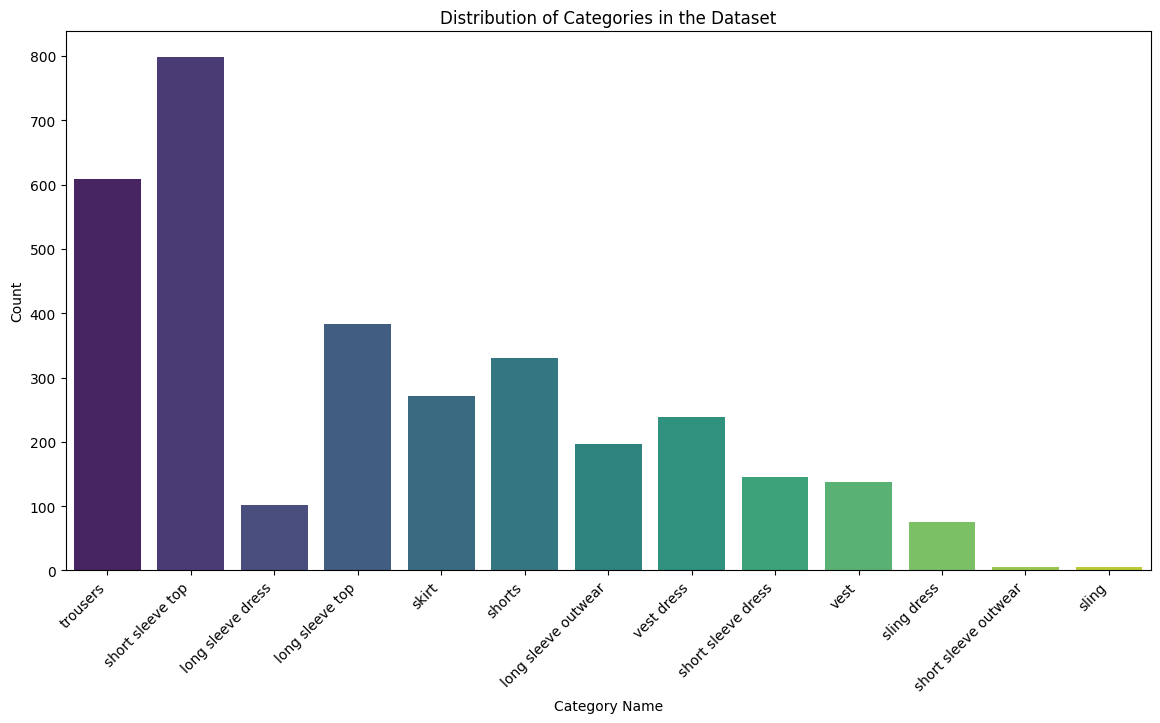

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


categories, counts = zip(*category_distribution.items())

plt.figure(figsize=(14, 7))
sns.barplot(x=list(categories), y=list(counts), palette='viridis')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.title('Distribution of Categories in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
import os
import json
import numpy as np
from tqdm.notebook import tqdm

annos_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_annos'

def determine_max_segmentation_length(annos_path, max_samples=2000):
    max_length = 0

    # Get list of annotation files
    anno_files = sorted(os.listdir(annos_path))[:max_samples]

    for anno_file in tqdm(anno_files, total=len(anno_files)):
        anno_path = os.path.join(annos_path, anno_file)

        try:
            with open(anno_path, 'r') as f:
                annotation = json.load(f)
                for item_key, item_value in annotation.items():
                    if item_key.startswith('item'):
                        segmentation = item_value.get('segmentation', [])
                        
                        # Flatten and calculate the length of the segmentation
                        flattened_segmentation = np.array([point for sublist in segmentation for point in sublist])
                        segmentation_length = len(flattened_segmentation)
                        
                        # Update the max length if this segmentation is longer
                        if segmentation_length > max_length:
                            max_length = segmentation_length

        except Exception as e:
            print(f"Error reading or processing annotation file {anno_file}: {e}")

    return max_length

max_segmentation_length = determine_max_segmentation_length(annos_path, max_samples=2000)
print(f"Maximum segmentation length: {max_segmentation_length}")


  0%|          | 0/2000 [00:00<?, ?it/s]

Maximum segmentation length: 376


In [12]:
import os
import json
import numpy as np
from tqdm.notebook import tqdm

annos_path = 'D:/Infosys Springboard Project(clothing personal stylist)/sub_annos'

def determine_max_landmark_length(annos_path, max_samples=2000):
    max_length = 0

    # Get list of annotation files
    anno_files = sorted(os.listdir(annos_path))[:max_samples]

    for anno_file in tqdm(anno_files, total=len(anno_files)):
        anno_path = os.path.join(annos_path, anno_file)

        try:
            with open(anno_path, 'r') as f:
                annotation = json.load(f)
                for item_key, item_value in annotation.items():
                    if item_key.startswith('item'):
                        landmarks = item_value.get('landmarks', [])
                        
            
                        landmarks_length = len(landmarks)
                        

                        if landmarks_length > max_length:
                            max_length = landmarks_length

        except Exception as e:
            print(f"Error reading or processing annotation file {anno_file}: {e}")

    return max_length

max_landmark_length = determine_max_landmark_length(annos_path, max_samples=2000)
print(f"Maximum landmark length: {max_landmark_length}")


  0%|          | 0/2000 [00:00<?, ?it/s]

Maximum landmark length: 117


In [13]:
import os
import json
import numpy as np
from tqdm.notebook import tqdm

def pad_or_truncate(sequence, max_length):
    if len(sequence) >= max_length:
        return sequence[:max_length]
    else:
        return np.pad(sequence, (0, max_length - len(sequence)), 'constant')

def load_and_process_annotations(annos_path, max_samples=2000):
    features_list = []
    labels_list = []

    anno_files = sorted(os.listdir(annos_path))[:max_samples]

    for anno_file in tqdm(anno_files, total=len(anno_files)):
        anno_path = os.path.join(annos_path, anno_file)
        
        try:
            with open(anno_path, 'r') as f:
                annotation = json.load(f)
                
                for item_key, item_value in annotation.items():
                    if item_key.startswith('item'):
                        category_name = item_value.get('category_name', "Unknown")
                        category_id = item_value.get('category_id', -1)
                        scale = item_value.get('scale', 1)
                        viewpoint = item_value.get('viewpoint', 1)
                        zoom_in = item_value.get('zoom_in', 1)
                        style = item_value.get('style', 1)
                        segmentation = item_value.get('segmentation', [])
                        bounding_box = item_value.get('bounding_box', [0, 0, 0, 0])
                        landmarks = item_value.get('landmarks', [])
                        occlusion = item_value.get('occlusion', 0)

         
                        flattened_segmentation = np.array([point for sublist in segmentation for point in sublist])
                        if flattened_segmentation.size > 0:
                            flattened_segmentation = flattened_segmentation / np.max(flattened_segmentation)
                        flattened_segmentation = pad_or_truncate(flattened_segmentation, 376)

                        
                        bounding_box = np.array(bounding_box) / np.max(bounding_box)

                        
                        if landmarks:
                            landmarks = np.array(landmarks).reshape(-1, 3)
                            if np.max(landmarks) > 0:
                                landmarks = landmarks / np.max(landmarks, axis=0)
                            landmarks = landmarks.flatten()
                        landmarks = pad_or_truncate(landmarks, 117)

                       
                        feature_vector = np.concatenate([
                            bounding_box,
                            flattened_segmentation,
                            landmarks,
                            [scale, viewpoint, zoom_in, style, occlusion]
                        ])

                        features_list.append(feature_vector)
                        labels_list.append(category_name)
        
        except Exception as e:
            print(f"Error reading or processing annotation file {anno_file}: {e}")

    return np.array(features_list), np.array(labels_list)

features, labels = load_and_process_annotations(annos_path, max_samples=2000)

# Display the shape of the feature and label arrays
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Features shape: (3297, 502)
Labels shape: (3297,)


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels (category names) into integers
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

print(f"Encoded labels: {numerical_labels[:10]}")


Encoded labels: [10  5  5  5  0  0  0  0  0  0]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features, numerical_labels, test_size=0.2, random_state=42)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.applications import ResNet50

input_shape = (X_train.shape[1],)  # Shape of the feature vector

# Create the base model from the pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

inputs = Input(shape=input_shape)
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5087 - loss: 1.5788 - val_accuracy: 0.8939 - val_loss: 0.3498
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8703 - loss: 0.4333 - val_accuracy: 0.9439 - val_loss: 0.2113
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9167 - loss: 0.2769 - val_accuracy: 0.9394 - val_loss: 0.1643
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9279 - loss: 0.2345 - val_accuracy: 0.9379 - val_loss: 0.1736
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9429 - loss: 0.1876 - val_accuracy: 0.9530 - val_loss: 0.1328
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9474 - loss: 0.1609 - val_accuracy: 0.9485 - val_loss: 0.1318
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9668 - loss: 0.1150 - val_accuracy: 0.9667 - val_loss: 0.1082
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9690 - loss: 0.0896 - val_accuracy: 0.9545 - val_los

In [18]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.1492 
Validation Loss: 0.12502099573612213
Validation Accuracy: 0.9621211886405945


In [19]:
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9634 - loss: 0.1060 - val_accuracy: 0.9636 - val_loss: 0.1165
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9732 - loss: 0.0785 - val_accuracy: 0.9667 - val_loss: 0.1119
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9718 - loss: 0.0884 - val_accuracy: 0.9652 - val_loss: 0.1102
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9825 - loss: 0.0644 - val_accuracy: 0.9652 - val_loss: 0.1082
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9808 - loss: 0.0656 - val_accuracy: 0.9667 - val_loss: 0.1072


In [20]:
model.save('clothing_personal_stylist_model.h5')

In [21]:
from tensorflow.keras.models import load_model

model = load_model('clothing_personal_stylist_model.h5')

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
import json
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

label_encoder_dict = {
    "classes": label_encoder.classes_.tolist()
}
with open('label_encoder.json', 'w') as f:
    json.dump(label_encoder_dict, f)
